# Problem Set 2: Risk Measures

## Task 1: Estimation, Interpretation

### a)

In [24]:
import pandas as pd
import numpy as np
from scipy.stats import norm, kurtosis, skew
import matplotlib.pyplot as plt
import statsmodels.api as sm
import datetime as dt
from dateutil.relativedelta import relativedelta

In [2]:
confidence_level = 0.95

In [3]:
data = pd.read_csv(r'PS2 - Data.csv', index_col = 0)
data.set_index('date', drop = True, inplace = True)
print(data.head(n = 5))

            JP_MORGAN_CHASE  EXXON_MOBIL     INTEL    PFIZER    BOEING  \
date                                                                     
1973-01-03        -0.002300     0.012800 -0.009900  0.002900  0.023900   
1973-01-04         0.000000     0.002765 -0.009999  0.011367 -0.009278   
1973-01-05        -0.002406     0.005612  0.000000  0.005718 -0.018927   
1973-01-08         0.002411     0.004210  0.010100 -0.022547  0.014469   
1973-01-09        -0.007016     0.000000  0.029997  0.000000 -0.014263   

                 RF  
date                 
1973-01-03  0.00021  
1973-01-04  0.00021  
1973-01-05  0.00021  
1973-01-08  0.00021  
1973-01-09  0.00021  


In [4]:
weights = [1/5, 1/5, 1/5, 1/5, 1/5]

dates = np.array(data.index)
stocks = np.array(data.columns[0:5])

portfolio = pd.DataFrame()
for date in dates:
    portfolio_return = 0
    for stock, weight in zip(stocks, weights):
        portfolio_return += data.loc[date, stock] * weight
    portfolio.loc[date, 'PORTFOLIO RETURN'] = portfolio_return
print(portfolio)

            PORTFOLIO RETURN
1973-01-03          0.005480
1973-01-04         -0.001029
1973-01-05         -0.002000
1973-01-08          0.001729
1973-01-09          0.001744
...                      ...
2021-07-20          0.022429
2021-07-21          0.019044
2021-07-22         -0.005043
2021-07-23         -0.009607
2021-07-26          0.015867

[12248 rows x 1 columns]


In [8]:
assets = np.concatenate([['PORTFOLIO'], stocks])
measures = np.array(['Mean Absolute Deviation', 'Semi Std', 'Empirical VaR', 'Empirical ES'])

data_agg = pd.concat([portfolio, data], axis = 1)
data_agg.drop('RF', axis = 1, inplace = True)
data_agg.rename(columns = {'PORTFOLIO RETURN': 'PORTFOLIO'}, inplace = True)
risk_measures = pd.DataFrame(index = measures, columns = assets)

periods = len(data_agg.index)
dates = np.array(data_agg.index)
assets = np.array(data_agg.columns)

# Quantile Generation Check
normal_dist = pd.Series(np.random.normal(loc = 0.0, scale = 1.0, size = 100000))
return_quantile_normal = normal_dist.quantile(q = 1-confidence_level)

print(f'\nQuantile Check of N(0,1): {round(return_quantile_normal, 2)}\n')

for asset in assets:
    return_mean = data_agg[asset].mean()
    return_variance = data_agg[asset].var()
    return_quantile = data_agg[asset].quantile(q = 1-confidence_level)
    absolute_deviation = 0
    semi_variance = 0
    for date in dates:
        if data_agg.loc[date, asset] <= return_mean:
            delta = 1
        else:
            delta = 0
        absolute_deviation += np.absolute(data_agg.loc[date, asset] - return_mean)
        semi_variance += delta * ((data_agg.loc[date, asset] - return_mean)**2)
    mean_absolute_deviation = absolute_deviation / periods
    semi_variance = semi_variance / periods
    semi_std = np.sqrt(semi_variance)
    # empirical_var = -(return_mean + (return_quantile * np.sqrt(return_variance)))
    empirical_var = -return_quantile
    deltas = 0
    empirical_es = 0
    for date in dates:
        if data_agg.loc[date, asset] <= -empirical_var:
            delta = 1
        else:
            delta = 0
        deltas += delta
        empirical_es += delta * data_agg.loc[date, asset]
    empirical_es = (-1/deltas) * empirical_es
    risk_measures.loc['Mean Absolute Deviation', asset] = round(mean_absolute_deviation, 5)
    risk_measures.loc['Semi Std', asset] = round(semi_std, 5)
    risk_measures.loc['Empirical VaR', asset] = round(empirical_var, 5)
    risk_measures.loc['Empirical ES', asset] = round(empirical_es, 5)
    
print(risk_measures)


Quantile Check of N(0,1): -1.66

                        PORTFOLIO JP_MORGAN_CHASE EXXON_MOBIL    INTEL  \
Mean Absolute Deviation   0.00979         0.01435     0.01052  0.01865   
Semi Std                  0.00993         0.01486     0.01054  0.01889   
Empirical VaR             0.02051         0.03047     0.02191  0.03847   
Empirical ES              0.03094         0.04741     0.03286  0.05986   

                          PFIZER   BOEING  
Mean Absolute Deviation  0.01239  0.01455  
Semi Std                 0.01204  0.01451  
Empirical VaR            0.02559   0.0299  
Empirical ES             0.03801  0.04564  


### b)

seen in the solution sheet

### c)

In [10]:
dates = np.array(portfolio.index)

portfolio_value = 100
monthly_portfolio = pd.DataFrame(index = dates, columns = ['PORTFOLIO VALUE'])
for date in dates:
    daily_return = portfolio.loc[date, 'PORTFOLIO RETURN']
    portfolio_value = portfolio_value * (1 + daily_return)
    monthly_portfolio.loc[date, 'PORTFOLIO VALUE'] = portfolio_value

monthly_portfolio['MONTHLY PORTFOLIO RETURN'] = monthly_portfolio['PORTFOLIO VALUE'].pct_change(periods = 21)
monthly_portfolio.drop('PORTFOLIO VALUE', axis = 1, inplace = True)
monthly_portfolio.dropna(axis = 0, inplace = True)
    
print(monthly_portfolio)

            MONTHLY PORTFOLIO RETURN
1973-02-02                 -0.056548
1973-02-05                 -0.063560
1973-02-06                 -0.072307
1973-02-07                 -0.084580
1973-02-08                 -0.082514
...                              ...
2021-07-20                 -0.018334
2021-07-21                 -0.020397
2021-07-22                 -0.028526
2021-07-23                 -0.035449
2021-07-26                 -0.031808

[12227 rows x 1 columns]


In [7]:
monthly_measures = pd.DataFrame(index = ['Empirical VaR', 'Theoretical VaR', 'Empirical ES', 'Theoretical ES'], columns = ['MONTHLY PORTFOLIO RETURN'])
dates = np.array(monthly_portfolio.index)

normal_dist = pd.Series(np.random.normal(loc = 0.0, scale = 1.0, size = 100000))
return_quantile_normal = normal_dist.quantile(q = 1-confidence_level)

monthly_return_mean = monthly_portfolio['MONTHLY PORTFOLIO RETURN'].mean()
monthly_return_variance = monthly_portfolio['MONTHLY PORTFOLIO RETURN'].var()
monthly_return_quantile = monthly_portfolio['MONTHLY PORTFOLIO RETURN'].quantile(q = 1-confidence_level)

empirical_var = -return_quantile
theoretical_var = -(monthly_return_mean + (return_quantile_normal * np.sqrt(monthly_return_variance)))

empirical_es = 0
for date in dates:
    if monthly_portfolio.loc[date, 'MONTHLY PORTFOLIO RETURN'] <= -empirical_var:
        delta = 1
    else:
        delta = 0
    deltas += delta
    empirical_es += delta * monthly_portfolio.loc[date, 'MONTHLY PORTFOLIO RETURN']
empirical_es = (-1/deltas) * empirical_es

theoretical_es = 0
for date in dates:
    if monthly_portfolio.loc[date, 'MONTHLY PORTFOLIO RETURN'] <= -theoretical_var:
        delta = 1
    else:
        delta = 0
    deltas += delta
    theoretical_es += delta * monthly_portfolio.loc[date, 'MONTHLY PORTFOLIO RETURN']
theoretical_es = (-1/deltas) * theoretical_es

monthly_measures.loc['Empirical VaR', 'MONTHLY PORTFOLIO RETURN'] = round(empirical_var, 5)
monthly_measures.loc['Theoretical VaR', 'MONTHLY PORTFOLIO RETURN'] = round(theoretical_var, 5)
monthly_measures.loc['Empirical ES', 'MONTHLY PORTFOLIO RETURN'] = round(empirical_es, 5)
monthly_measures.loc['Theoretical ES', 'MONTHLY PORTFOLIO RETURN'] = round(theoretical_es, 5)
    
print(monthly_measures)

                MONTHLY PORTFOLIO RETURN
Empirical VaR                     0.0299
Theoretical VaR                  0.08235
Empirical ES                      0.0545
Theoretical ES                   0.02073


### d)

In [9]:
dates = [dt.datetime.strptime(i, '%Y-%m-%d').date() for i in np.array(monthly_portfolio.index)]
monthly_portfolio.index = [dt.datetime.strptime(j, '%Y-%m-%d').date() for j in np.array(monthly_portfolio.index)]
portfolio.index = [dt.datetime.strptime(k, '%Y-%m-%d').date() for k in np.array(portfolio.index)]

In [9]:
log_prices = np.log(monthly_portfolio['MONTHLY PORTFOLIO RETURN'] + 1)
plot_data = pd.DataFrame(index = np.array(monthly_portfolio.index), columns = ['LOG PRICES', 'SEMI STD'])

first_date = dates[0] + relativedelta(years = 5)
for date in dates:
    if date < first_date:
        plot_data.loc[date, 'LOG PRICES'] = np.nan
        plot_data.loc[date, 'SEMI STD'] = np.nan
    else:
        end_date = date
        start_date = end_date - relativedelta(years = 5)
        after_start_date = monthly_portfolio.index >= start_date
        before_end_date = monthly_portfolio.index <= end_date
        between_start_end_date = after_start_date & before_end_date
        rolling_monthly_portfolio = monthly_portfolio.loc[between_start_end_date]

        rolling_dates = np.array(rolling_monthly_portfolio.index)
        return_mean = rolling_monthly_portfolio['MONTHLY PORTFOLIO RETURN'].mean()
        periods = len(np.array(rolling_monthly_portfolio.index))
        
        price = 100
        semi_variance = 0
        for rolling_date in rolling_dates:
            price = price * (1 + portfolio.loc[rolling_date, ['PORTFOLIO RETURN']][0])
            if rolling_monthly_portfolio.loc[rolling_date, ['MONTHLY PORTFOLIO RETURN']][0] <= return_mean:
                delta = 1
            else:
                delta = 0
            semi_variance += delta * ((rolling_monthly_portfolio.loc[rolling_date, ['MONTHLY PORTFOLIO RETURN']][0] - return_mean)**2)
        semi_variance = semi_variance / periods
        semi_std = np.sqrt(semi_variance)
        plot_data.loc[date, 'LOG PRICES'] = np.log(price) - np.log(100)
        plot_data.loc[date, 'SEMI STD'] = semi_std

print(plot_data)

           LOG PRICES  SEMI STD
1973-02-02        NaN       NaN
1973-02-05        NaN       NaN
1973-02-06        NaN       NaN
1973-02-07        NaN       NaN
1973-02-08        NaN       NaN
...               ...       ...
2021-07-20   0.566714  0.051648
2021-07-21   0.583126  0.051634
2021-07-22   0.588607  0.051627
2021-07-23   0.575171  0.051619
2021-07-26   0.595709  0.051617

[12227 rows x 2 columns]


In [10]:
x = plot_data.index
y_1 = plot_data['LOG PRICES'].to_numpy()
y_2 = plot_data['SEMI STD'].to_numpy()

fig, ax1 = plt.subplots()
fig.set_size_inches(10, 6)

color = 'tab:red'
ax1.set_xlabel('Dates', size = 14)
ax1.set_ylabel('log Prices', color = color, size = 14)
ax1.plot(x, y_1, color = color)
ax1.tick_params(axis = 'y', labelcolor = color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Semi Std Estimations', color = color, size = 14) 
ax2.plot(x, y_2, color = color)
ax2.tick_params(axis = 'y', labelcolor = color)

plt.show()

NameError: name 'plot_data' is not defined

### e)

see in the solution sheet

### f)

In [13]:
monthly_return_mean = monthly_portfolio['MONTHLY PORTFOLIO RETURN'].mean()
monthly_return_median = monthly_portfolio['MONTHLY PORTFOLIO RETURN'].median()

print("The mean of the return series is ", round(monthly_return_mean, 5))
print("The median of the return series is ", round(monthly_return_median, 5))

The mean of the return series is  0.01475
The median of the return series is  0.01562


### g)

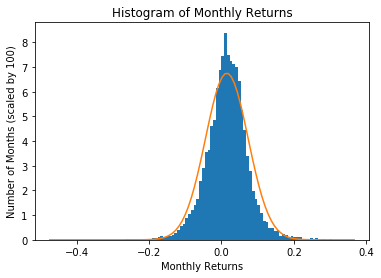

In [28]:
plot2_mean = monthly_return_mean
plot2_std = monthly_portfolio['MONTHLY PORTFOLIO RETURN'].std()
plt.hist(monthly_portfolio.to_numpy(), weights=np.ones(len(monthly_portfolio)) / 100, bins=100)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, plot2_mean, plot2_std)

plt.plot(x, p)
plt.xlabel('Monthly Returns')
plt.ylabel('Number of Months (scaled by 100)')
plt.title('Histogram of Monthly Returns')
plt.show()

### h)

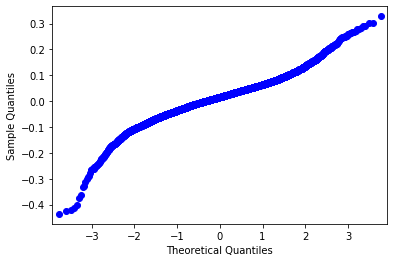


The Skweness of the return series is  -0.29902628962572997
The Kurtosis of the return series is  3.730311799070156


In [30]:
qqplot_data = np.array(monthly_portfolio['MONTHLY PORTFOLIO RETURN'])
pplot = sm.ProbPlot(qqplot_data, fit=False)
fig = pplot.qqplot()
plt.show()

print("\nThe Skewness of the return series is ", skew(monthly_portfolio, bias=False)[0])
print("The Kurtosis of the return series is ", kurtosis(monthly_portfolio, bias=False)[0])

## 2)

### a)

In [46]:
# Risk Free Data
risk_free_returns = data['RF']
risk_free_returns.index = pd.to_datetime(risk_free_returns.index)

# Equally Weighted Risky Portfolio Data
risky_returns = portfolio
risky_returns.index = pd.to_datetime(risky_returns.index)
# risky_returns.index = risky_returns.index.strftime('%Y-%m-%d')
# -----
portfolio.index = pd.to_datetime(portfolio.index)
monthly_equity_return = portfolio.resample('M').sum()
months = monthly_equity_return.index.strftime('%Y-%m')
months = months.to_numpy()
monthly_equity_return.index = monthly_equity_return.index.strftime('%Y-%m-%d')

risky_returns[0:20].mean()

PORTFOLIO RETURN   -0.00166
dtype: float64

In [93]:
# Constants
target_VaR = 0.05
confidence_level = 0.99
lambda_fixed = 0.95
w_1 = 0.5
quantile = -2.33

weights = [w_1]
portfolio_returns = []
rolling_portfolio_variances = []
mean_returns = []

for month in months:
    if month == '1973-01':
        portfolio_return = w_1 * risky_returns[risky_returns.index.strftime('%Y-%m') == month].sum()[0] + (1-w_1) * risk_free_returns[risk_free_returns.index.strftime('%Y-%m') == month][0]
        portfolio_returns.append(portfolio_return)
        portfolio_variance = w_1**2 * risky_returns[risky_returns.index.strftime('%Y-%m') <= month].var() # ==
        rolling_portfolio_variances.append(portfolio_variance[0])
        mean_returns.append(portfolio_return)
    else:
        month_differenced = dt.datetime.strptime(month, '%Y-%m') - relativedelta(months = 1)
        month_differenced = month_differenced.strftime('%Y-%m')
        portfolio_return = weights[-1] * risky_returns[risky_returns.index.strftime('%Y-%m') == month_differenced].sum()[0] + (1-weights[-1]) * risk_free_returns[risk_free_returns.index.strftime('%Y-%m') == month_differenced][0]
        portfolio_returns.append(portfolio_return)
        last_day_return = weights[-1] * risky_returns[risky_returns.index.strftime('%Y-%m') == month_differenced].iloc[-1][0] + (1-weights[-1]) * risk_free_returns[risk_free_returns.index.strftime('%Y-%m') == month_differenced][0]
        rolling_mean_return = np.mean(portfolio_returns)
        rolling_portfolio_variance = lambda_fixed * rolling_portfolio_variances[-1] + (1-lambda_fixed) * (last_day_return - rolling_mean_return)**2
        rolling_portfolio_variances.append(rolling_portfolio_variance)
        # ----
        R_rf = risk_free_returns[risk_free_returns.index.strftime('%Y-%m') == month][0]
        mean_return = lambda_fixed * rolling_mean_return + (1-lambda_fixed) * last_day_return
        mean_returns.append(mean_return)
        std_risky = np.sqrt((lambda_fixed * rolling_portfolio_variance + (1-lambda_fixed) * (last_day_return - rolling_mean_return)**2))
        # ----
        w = -((R_rf + target_VaR)/((quantile * std_risky) + mean_return))
        if w > 10:
            w = 10
        elif w < 0:
            w = 0
        weights.append(w)
        
price = 100
prices = []
for i in range(0, len(portfolio_returns)):
    price = price * (1 + portfolio_returns[i])
    prices.append(price)
        
portfolio_summary = pd.DataFrame(index = [months[0:583]], columns = ['w_risky', 'w_rf', 'Return', 'Mean_Return', 'Std', 'Price'])
portfolio_summary['w_risky'] = weights
portfolio_summary['w_rf'] = 1 - portfolio_summary['w_risky']
portfolio_summary['Return'] = portfolio_returns
portfolio_summary['Mean_Return'] = mean_returns
portfolio_summary['Std'] = np.sqrt(rolling_portfolio_variances)
portfolio_summary['Price'] = prices

print(portfolio_summary, '\n')

total_mean_return = np.mean(portfolio_returns)
total_mean_std = np.std(portfolio_returns)

print(f"Mean Portfolio Return: {total_mean_return}")
print(f"Portfolio Volatility: {total_mean_std}")

          w_risky      w_rf    Return  Mean_Return       Std          Price
1973-01  0.500000  0.500000 -0.016497    -0.016497  0.003535      98.350270
1973-02  1.536876 -0.536876 -0.016497    -0.015442  0.005843      96.727756
1973-03  0.850694  0.149306 -0.070570    -0.032967  0.008987      89.901688
1973-04  1.053510 -0.053510  0.005686    -0.023525  0.009726      90.412832
1973-05  0.954646  0.045354 -0.016736    -0.021366  0.011761      88.899715
...           ...       ...       ...          ...       ...            ...
2021-03  1.102240 -0.102240  0.109329     0.016016  0.025811  588205.068762
2021-04  1.184924 -0.184924  0.088347     0.016858  0.025573  640171.133358
2021-05  1.118411 -0.118411 -0.017121     0.016267  0.025880  629210.887044
2021-06  1.157236 -0.157236  0.038977     0.016665  0.025786  653735.692341
2021-07  1.232102 -0.232102 -0.000535     0.017208  0.025286  653386.091195

[583 rows x 6 columns] 

Mean Portfolio Return: 0.01782964918752968.
Portfolio Volatili

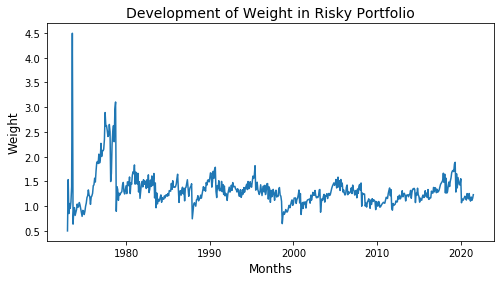

In [94]:
months_datetime = [dt.datetime.strptime(date, "%Y-%m").date() for date in months]
plt.figure(figsize = (8,4))
plt.plot(months_datetime, portfolio_summary['w_risky'].to_numpy()) 
plt.xlabel('Months', size = 12)
plt.ylabel('Weight', size = 12)
plt.title('Development of Weight in Risky Portfolio', size = 14)
plt.show()

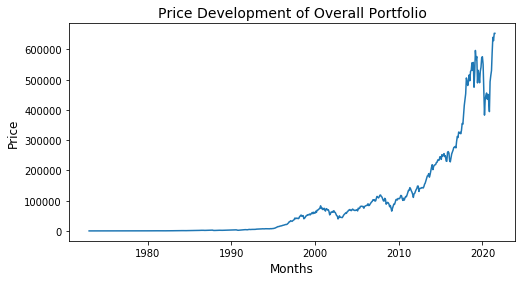

In [95]:
plt.figure(figsize = (8,4))
plt.plot(months_datetime, portfolio_summary['Price'].to_numpy())
plt.xlabel('Months', size = 12)
plt.ylabel('Price', size = 12)
plt.title('Price Development of Overall Portfolio', size = 14)
plt.show()

### b)

In [96]:
# Monthly realized VaR
VaRs = []
exceeded_months = []
exceeded_VaRs = []
for i in range(0, len(months)):
    filtered = portfolio_summary.iloc[0:i]
    mean_return = mean_returns[i]
    std = np.sqrt(rolling_portfolio_variances[i])
    VaR = -(mean_return + quantile * std)
    VaRs.append(VaR)
    if VaR >= target_VaR:
        exceeded_months.append(filtered.index[-1])
        exceeded_VaRs.append(VaR)

print(f"Number of exceeded months: {len(exceeded_months)}.")

for i in range(0, len(exceeded_months)):
    print(f"Exceeded months: {exceeded_months[i][0]} - VaR: {round(exceeded_VaRs[i], 4)}")

Number of exceeded months: 40.
Exceeded months: 1973-02 - VaR: 0.0539
Exceeded months: 1973-08 - VaR: 0.0619
Exceeded months: 1973-09 - VaR: 0.0568
Exceeded months: 1973-10 - VaR: 0.0525
Exceeded months: 1973-11 - VaR: 0.0631
Exceeded months: 1973-12 - VaR: 0.0585
Exceeded months: 1974-01 - VaR: 0.055
Exceeded months: 1974-03 - VaR: 0.0524
Exceeded months: 1974-04 - VaR: 0.0516
Exceeded months: 1974-07 - VaR: 0.0542
Exceeded months: 1974-08 - VaR: 0.0576
Exceeded months: 1974-09 - VaR: 0.0635
Exceeded months: 1974-10 - VaR: 0.0529
Exceeded months: 1974-11 - VaR: 0.0545
Exceeded months: 1974-12 - VaR: 0.0588
Exceeded months: 1975-01 - VaR: 0.0551
Exceeded months: 1975-02 - VaR: 0.0504
Exceeded months: 1987-11 - VaR: 0.056
Exceeded months: 1987-12 - VaR: 0.0547
Exceeded months: 1988-01 - VaR: 0.0503
Exceeded months: 1998-08 - VaR: 0.0643
Exceeded months: 1998-09 - VaR: 0.0616
Exceeded months: 1998-10 - VaR: 0.0584
Exceeded months: 1998-11 - VaR: 0.0597
Exceeded months: 1998-12 - VaR: 0.0

### c)

see in the solution sheet